**1. Introdução e Setup**

In [31]:
# Instalação da biblioteca de modulação
!pip install ModulationPy -q

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from ModulationPy import QAMModem
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from scipy.signal import welch
import os


# Early Stopping
callback_dpd = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=50,
    min_delta=1e-9,
    restore_best_weights=True
)

**2. Teste da GPU**

In [32]:
# %% Verificação da GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('Connected without GPU Device')
else:
  print('Connected with GPU Device')

Connected with GPU Device


**3. Parâmetros do Sistema OFDM**

In [33]:
# --- CONFIGURAÇÕES DO SISTEMA ---
K = 2048                                  # Número de subportadoras (Tamanho da FFT)
NUM_BLOCOS = 10                           # Quantidade de blocos OFDM para processamento
SUBPORT_ATIVAS = np.arange(-200, 201, 1)  # Espectro ocupado
MOD_ORDER = 16                            # 16-QAM
SNR_DB = 45                               # Relação Sinal-Ruído do canal
J = 2                                     # Ordem do modelo polinomial do modulador (Não-linearidade)

**4. Funções de Apoio**

In [34]:
def suavizar_espectro(vetor_db, janela=20):
    """Aplica uma média móvel robusta para deixar o gráfico da DEP bem suave."""
    return np.convolve(vetor_db, np.ones(janela)/janela, mode='same')

def modular_qam(bits_ou_indices, ordem):
    """Realiza a modulação QAM e normaliza a potência unitária."""
    modem = QAMModem(ordem, bin_input=False, soft_decision=False, bin_output=False)
    simbolos = modem.modulate(bits_ou_indices)
    potencia_media = np.mean(np.abs(simbolos)**2)
    simbolos_norm = simbolos * np.sqrt(1 / potencia_media)
    return simbolos_norm, modem

def mapear_ofdm(simbolos_qam, indices_ativos, tamanho_fft):
    """Aloca os símbolos QAM nas subportadoras específicas da FFT."""
    espectro = np.zeros(tamanho_fft, dtype=complex)
    espectro[indices_ativos] = simbolos_qam
    return espectro

def canal_awgn(sinal, snr_db, pot_referencia):
    """Adiciona ruído gaussiano branco (AWGN) baseado na SNR desejada."""
    sigma2 = pot_referencia * 10**(-snr_db/10)
    ruido = np.sqrt(sigma2/2) * (np.random.randn(*sinal.shape) + 1j*np.random.randn(*sinal.shape))
    return sinal + ruido

def modelo_mzm(coeficientes, sinal_in, ordem):
    """Representa o comportamento não-linear do Modulador Mach-Zehnder."""
    # Matriz onde cada coluna é o sinal elevado a uma potência ímpar (comum em RF)
    X = np.column_stack([sinal_in * np.abs(sinal_in)**k for k in range(ordem)])
    return X.dot(coeficientes)

def calcular_evm(simbolos_est, simbolos_ref):
    """Calcula o Error Vector Magnitude em porcentagem."""
    erro = simbolos_est - simbolos_ref
    return np.sqrt(np.mean(np.abs(erro)**2) / np.mean(np.abs(simbolos_ref)**2)) * 100

def calcular_mer(simbolos_est, simbolos_ref):
    """Calcula o Modulation Error Ratio em dB."""
    erro = simbolos_est - simbolos_ref
    p_sinal = np.mean(np.abs(simbolos_ref)**2)
    p_erro = np.mean(np.abs(erro)**2)
    return 10 * np.log10(p_sinal / p_erro)

**5. Carregando os Coeficientes do Modelo Polinomial**

In [35]:
# --- GERAÇÃO DE DADOS E CANAL (CENÁRIO SEM DPD) ---


# Link para o arquivo RAW no seu GitHub
# Substitua 'SEU_USUARIO' e 'SEU_REPOSITORIO' pelos seus dados reais
url_coef = "https://raw.githubusercontent.com/luiz10ml/Curso-Pratico-Optica/main/coeficientes/coef"


# Faz o download do arquivo para o ambiente do Colab
if not os.path.exists("coef"):
    !wget {url_coef} -O coef

# Carregamento dos dados
coef_mzm = np.fromfile("coef", dtype=np.complex64)

print(f"Coeficientes carregados com sucesso!: {coef_mzm}")


Coeficientes carregados com sucesso!: [0.3909852 -0.11061279j 0.28564334-0.08432291j]


**6. Geração dos dados**

In [36]:
# Vetores para armazenar o sinal completo
sinal_tx_total = np.zeros(NUM_BLOCOS * K, dtype=complex)

for i in range(NUM_BLOCOS):
    p_tx_dbm = np.random.randint(-5, 16)
    p_tx_linear = 10**(p_tx_dbm/10) * 1e-3

    indices = np.random.randint(0, MOD_ORDER, size=len(SUBPORT_ATIVAS))
    qam_norm, _ = modular_qam(indices, MOD_ORDER)

    espectro_mapeado = mapear_ofdm(qam_norm, SUBPORT_ATIVAS, K)
    sinal_tempo = np.fft.ifft(espectro_mapeado) * np.sqrt(K)

    escala = np.sqrt(p_tx_linear / np.mean(np.abs(sinal_tempo)**2))
    sinal_tx_total[i*K : (i+1)*K] = sinal_tempo * escala

# Passagem pelo Modulador Não-Linear (MZM) e Canal
sinal_distorcido = modelo_mzm(coef_mzm, sinal_tx_total, J)
sinal_recebido = canal_awgn(sinal_distorcido, SNR_DB, np.mean(np.abs(sinal_tx_total)**2))

**7. Arquitetura e Treinamento da Rede Neural (DPD)**

In [37]:
X_train = np.c_[sinal_recebido.real, sinal_recebido.imag]
y_train = np.c_[sinal_tx_total.real, sinal_tx_total.imag]

model_dpd = Sequential([
    Dense(2048, activation='relu', input_shape=(2,)),
    Dense(1024, activation='relu'),
    Dense(2)
])

model_dpd.compile(optimizer='adam', loss='mse')

model_dpd.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=K,
    verbose=2,
    callbacks=[callback_dpd]
)

Epoch 1/200
10/10 - 2s - 207ms/step - loss: 7.5360e-04
Epoch 2/200
10/10 - 0s - 43ms/step - loss: 1.5270e-04
Epoch 3/200
10/10 - 0s - 26ms/step - loss: 4.9648e-05
Epoch 4/200
10/10 - 0s - 25ms/step - loss: 1.8057e-05
Epoch 5/200
10/10 - 0s - 25ms/step - loss: 8.6693e-06
Epoch 6/200
10/10 - 0s - 29ms/step - loss: 4.8131e-06
Epoch 7/200
10/10 - 0s - 25ms/step - loss: 2.7018e-06
Epoch 8/200
10/10 - 0s - 31ms/step - loss: 1.8296e-06
Epoch 9/200
10/10 - 0s - 31ms/step - loss: 1.4420e-06
Epoch 10/200
10/10 - 0s - 24ms/step - loss: 1.1957e-06
Epoch 11/200
10/10 - 0s - 27ms/step - loss: 5.8413e-06
Epoch 12/200
10/10 - 0s - 24ms/step - loss: 3.5232e-05
Epoch 13/200
10/10 - 0s - 33ms/step - loss: 9.5777e-06
Epoch 14/200
10/10 - 0s - 21ms/step - loss: 3.0421e-06
Epoch 15/200
10/10 - 0s - 24ms/step - loss: 1.6141e-06
Epoch 16/200
10/10 - 0s - 26ms/step - loss: 1.0808e-06
Epoch 17/200
10/10 - 0s - 30ms/step - loss: 9.2532e-07
Epoch 18/200
10/10 - 0s - 28ms/step - loss: 7.2977e-07
Epoch 19/200
10/10

**8. Teste e Validação**

In [38]:
print("\n--- Avaliando Performance ---")
p_teste_dbm = 10
p_teste_lin = 10**(p_teste_dbm/10) * 1e-3

indices_teste = np.random.randint(0, MOD_ORDER, size=len(SUBPORT_ATIVAS))
qam_teste, modem_obj = modular_qam(indices_teste, MOD_ORDER)
sinal_ofdm_teste = np.fft.ifft(mapear_ofdm(qam_teste, SUBPORT_ATIVAS, K)) * np.sqrt(K)
sinal_ofdm_teste *= np.sqrt(p_teste_lin / np.mean(np.abs(sinal_ofdm_teste)**2))

# 1. Caso SEM DPD
saida_sem_dpd = modelo_mzm(coef_mzm, sinal_ofdm_teste, J)
energia_saida = np.mean(abs(saida_sem_dpd)**2)
saida_sem_dpd = saida_sem_dpd*np.sqrt(np.mean(abs(sinal_ofdm_teste)**2)/energia_saida)

# 2. Caso COM DPD
sinal_entrada_mlp = np.c_[sinal_ofdm_teste.real, sinal_ofdm_teste.imag]
sinal_pre_distorcido_raw = model_dpd.predict(sinal_entrada_mlp, verbose=0)
sinal_pre_distorcido = sinal_pre_distorcido_raw[:,0] + 1j*sinal_pre_distorcido_raw[:,1]
saida_com_dpd = modelo_mzm(coef_mzm, sinal_pre_distorcido, J)

# --- DEMODULAÇÃO E CÁLCULO DE MÉTRICAS ---
def processar_receptor(sinal_rx, ref_qam):
    rx_f = np.fft.fft(sinal_rx) / np.sqrt(K)
    qam_rx = rx_f[SUBPORT_ATIVAS]
    qam_rx *= np.sqrt(np.mean(np.abs(ref_qam)**2) / np.mean(np.abs(qam_rx)**2))
    evm_val = calcular_evm(qam_rx, ref_qam)
    mer_val = calcular_mer(qam_rx, ref_qam)
    return qam_rx, evm_val, mer_val

qam_sem, evm_sem, mer_sem = processar_receptor(saida_sem_dpd, qam_teste)
qam_com, evm_com, mer_com = processar_receptor(saida_com_dpd, qam_teste)


--- Avaliando Performance ---


**9. Análise Espectral**

In [39]:
f_ref, p_ref = welch(sinal_ofdm_teste, fs=1.0, window='hann', nperseg=K, return_onesided=False)
f_sem, p_sem = welch(saida_sem_dpd, fs=1.0, window='hann', nperseg=K, return_onesided=False)
f_com, p_com = welch(saida_com_dpd, fs=1.0, window='hann', nperseg=K, return_onesided=False)

# Suavização e centralização (Janela aumentada para suavizar mais)
db_ref = np.fft.fftshift(suavizar_espectro(10*np.log10(p_ref + 1e-12), janela=41))
db_sem = np.fft.fftshift(suavizar_espectro(10*np.log10(p_sem + 1e-12), janela=41))
db_com = np.fft.fftshift(suavizar_espectro(10*np.log10(p_com + 1e-12), janela=41))
f_plot = np.fft.fftshift(f_sem)

**10. Plotando os Resultados**

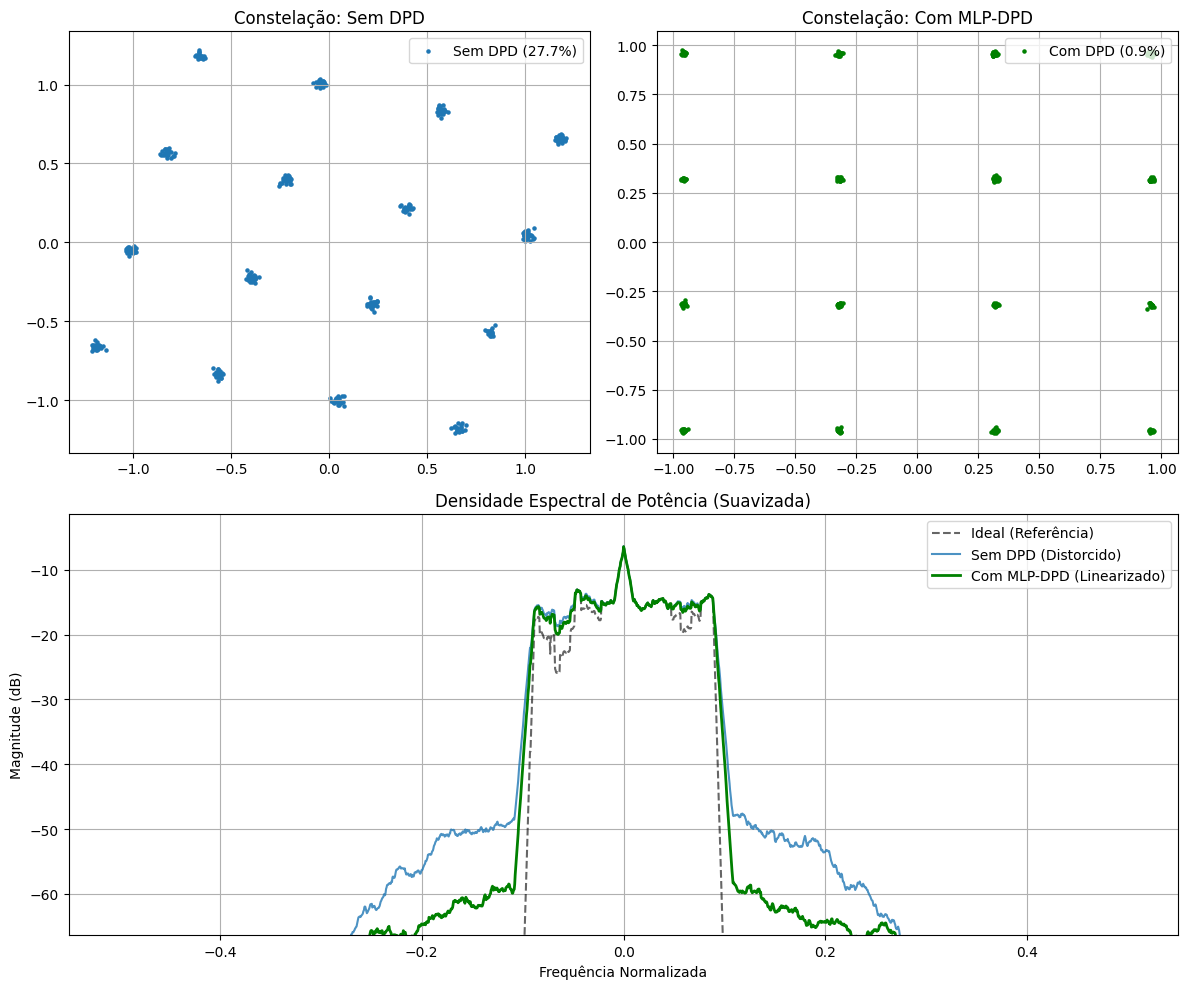

RESULTADO FINAL (10 dBm):
Sem DPD -> MER: 11.16 dB | EVM: 27.68%
Com DPD -> MER: 41.21 dB | EVM: 0.87%


In [40]:
plt.figure(figsize=(12, 10))

# Plot 1: Constelação Sem DPD (Topo Esquerda)
plt.subplot(221)
plt.scatter(qam_sem.real, qam_sem.imag, s=5, label=f'Sem DPD ({evm_sem:.1f}%)')
plt.title("Constelação: Sem DPD")
plt.grid(); plt.legend(loc='upper right')

# Plot 2: Constelação Com DPD (Topo Direita)
plt.subplot(222)
plt.scatter(qam_com.real, qam_com.imag, s=5, color='green', label=f'Com DPD ({evm_com:.1f}%)')
plt.title("Constelação: Com MLP-DPD")
plt.grid(); plt.legend(loc='upper right')

# Plot 3: Densidade Espectral de Potência (Base - Ocupando as duas colunas)
plt.subplot(212)
plt.plot(f_plot, db_ref, color='black', label='Ideal (Referência)', linestyle='--', alpha=0.6)
plt.plot(f_plot, db_sem, label='Sem DPD (Distorcido)', alpha=0.8)
plt.plot(f_plot, db_com, label='Com MLP-DPD (Linearizado)', color='green', linewidth=2)
plt.title("Densidade Espectral de Potência (Suavizada)")
plt.xlabel("Frequência Normalizada")
plt.ylabel("Magnitude (dB)")
plt.ylim(np.max(db_ref)-60, np.max(db_ref)+5)
plt.grid(); plt.legend()

plt.tight_layout()
plt.show()

print(f"RESULTADO FINAL ({p_teste_dbm} dBm):")
print(f"Sem DPD -> MER: {mer_sem:.2f} dB | EVM: {evm_sem:.2f}%")
print(f"Com DPD -> MER: {mer_com:.2f} dB | EVM: {evm_com:.2f}%")